# "Let Nature Be Your Teacher": Using Probabilistic Topic Modeling to Study "Nature" in William Wordsworth and S.T. Coleridge's _Lyrical Ballads_ (1800)

## Marc Vasquez

Instructions: 

1. Replace "yourname" in the title of this notebook, and "your name here" in the markdown above, with your name.
2. Create a title for your final project. Preferably, this should indicate what your argument is. Replace "your title here" in the markdown above with your title.
3. Write your paper, and include everything (your prose in Markdown, your code, and your figures) in this notebook. Don't include the texts you're analyzing. If you generated your corpus programmatically (i.e. using corpus-db.org or some fancy Python), maybe you'll want to include that in the code somewhere here. Your notebook file (`.ipynb`) will be the only thing you turn in.  
3. Annotate your code using markdown cells, and/or comment lines (lines beginning with `#`), explaining why you're doing what you're doing. If one of your functions takes certain parameters, for instance, why did you choose those parameters? 
3. Prune your notebook of unnecessary or redundant code. Run all your code again, to show that it works as-is. Each code cell should have a number in it, and an output, if applicable. 
4. Proofread well! If English is not your first language, you might consider making an appointment with [the Writing Center](https://slc.berkeley.edu/appointment-service) to get help polishing the language of your paper. At minimum, you'll want to use a spell checker and maybe even an automatic grammar-checking service like [Grammerly](https://www.grammarly.com/). (Of course, you now have the tools to analyze your own writing, if you want. You can get your markdown text into Python by adapting the word count function below, and use it to analyze your most frequent n-grams!) You might also consider organizing a mutual editing session with classmates.
4. Ensure that you have no more than three plots (figures). One figure with several subplots is OK, and counts as one figure.
4. If you quote from or reference literary works, or works of criticirm, provide in-text parenthetical citations. Then create a bibliographic entry for each work you cite, and include them at the end. Unless your discipline requires a different format, use [MLA Style](https://style.mla.org/) as the format for your bibliography, and title it "works cited." 
4. Replace the value of the `filename` variable in the wordcount cell below to the name your file. (E.g., `Jonathan-Final.ipynb`.) Then run the wordcount cell. Ensure that your paper is between 1000 and 2000 words, so it doesn't give you any errors or warnings.  
5. Optionally, and for a 5% bonus, add your notebook to the `/Projects` directory of the course repository, and submit it as a pull request. Your project will then become public. 
6. Email me your `.ipynb` file: jonathan.reeve@columbia.edu. Please email me only your `.ipynb` file, alone and uncompressed. Please don't respond to an existing email, but create a new email, with the subject: `Yourname: Final Project`, replacing `yourname` with your name. Do this regardless of whether you also submit a pull request. 
7. Celebrate! You've finished your final project, and gloriously completed _Introduction to Computational Literary Analysis_!

In [1]:
import nltk
from nltk import word_tokenize
from nltk.text import Text
from collections import Counter
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from IPython.nbformat import current

/anaconda3/lib/python3.6/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)
/anaconda3/lib/python3.6/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


In [2]:
# Read in the entire text
lyrical_ballads = open('LyricalBallads1800.txt').read()

# Split the collection into individual poems
LB_parts = lyrical_ballads.split('%%%%%')

# Check collection length
len(LB_parts)

55

In the Preface to the 1800 edition of _Lyrical Ballads_, a cornerstone of literary Romanticism, Wordsworth stresses that the "principal object" of this collection is, "above all, to make [incidents and situations from common life] interesting by tracing in them . . . the primary laws of our nature: chiefly, as far as regards the manner in which we associate ideas in a state of excitement" (97). This statement presents _Lyrical Ballads_ as a coherent and integrated collection, in which every poem represents some aspect of the fundamental "laws" of human nature--mainly, how the cognitive ("the manner in which we associate ideas") interacts with the affective ("in a state of excitement"). With these "primary" human laws as the uniting thread, Wordsworth preempts misconceptions of _Lyrical Ballads_ as a haphazard, disjunctive set of poems. But what exactly does "nature" signify as the collection moves forward? Does "nature" refer to discrete entities, human and non-human, or does it unsettle boundaries between different kinds of "nature"? The word "nature" can refer to many things: its senses range from physical, bodily, or mental power, strength, or substance (_Oxford English Dictionary_, I. and II.), to innate character (_OED_, III.), to physical phenomena, as opposed to humans and human creations (_OED_, IV.11.a.). Could a computational analysis yield a better understanding of the meaning(s) of "nature" in _Lyrical Ballads_?

This essay relies on probabilistic topic modeling to computationally examine "nature" in _Lyrical Ballads_. I begin by using a latent Dirichlet allocation (LDA) engine to generate the main themes of _Lyrical Ballads_, followed by a visualization of themes involving "nature." Then, I state my hypothesis and begin to test it with a concordance and co-occurrence, tracing "nature" distantly and closely. I conclude with close readings of representative passages from poems that pressure the topic model's typology of "nature."

## Topic Modeling

Before the topic modeling proper, a brief explanation of "probabilistic topic modeling" is in order. According to David Blei's "Probabilistic Topic Models," topic modeling algorithms enable us to discover the main themes of a corpus, thereby allowing us to organize the collection according to the discovered themes (77). In Blei's words, the algorithms behind topic modelling are "statistical methods that analyze the words of the original texts to discover the themes that run through them, how those themes are connected to each other, and how they change over time" (77-78). Thus, a "topic" is "a distribution over a fixed vocabulary" (Blei 78). The question that topic modeling allows me to answer is this: what are the main, distinctive themes that are distributed across the poems of _Lyrical Ballads_?

Let's prepare the text for topic modeling by dividing it into equal chunks:

In [3]:
def chunk(tokens, size):
    return list(zip(*[tokens[i::size] for i in range(size)]))

In [4]:
LB_tokens = word_tokenize(lyrical_ballads)

In [5]:
LB_chunks = chunk(LB_tokens, 500)

In [6]:
LB_chunks = [' '.join(chunk) for chunk in LB_chunks] 

In [7]:
len(LB_chunks)

121

In [8]:
[len(chunk) for chunk in LB_chunks[:10]]

[2624, 2671, 2831, 2720, 2802, 2610, 2548, 2711, 2761, 2734]

Below, I initialize a CountVectorizer function that shows me words that constitute at least 5%, and no more than 80%, of my 500-word chunks. These parameters ensure that the words in my topic model are distributed across the poems without being too common.

In [9]:
cv = CountVectorizer(min_df=0.05, max_df=0.8, stop_words='english') 

In [10]:
counts = cv.fit_transform(LB_chunks)
counts

<121x609 sparse matrix of type '<class 'numpy.int64'>'
	with 9161 stored elements in Compressed Sparse Row format>

In [11]:
word_labels = cv.get_feature_names()
word_labels[:100]

['act',
 'age',
 'aged',
 'ah',
 'air',
 'alas',
 'alive',
 'amid',
 'ancient',
 'answer',
 'appear',
 'april',
 'arm',
 'arms',
 'art',
 'away',
 'aye',
 'babe',
 'banks',
 'bear',
 'beat',
 'beauteous',
 'beautiful',
 'beauty',
 'bed',
 'began',
 'behold',
 'believe',
 'beneath',
 'best',
 'better',
 'betty',
 'bird',
 'birds',
 'birth',
 'black',
 'bless',
 'blew',
 'blind',
 'blood',
 'blue',
 'body',
 'bold',
 'bones',
 'books',
 'born',
 'bough',
 'bound',
 'bower',
 'boy',
 'boys',
 'brain',
 'break',
 'breast',
 'breath',
 'breeze',
 'bright',
 'bring',
 'brook',
 'brother',
 'brought',
 'build',
 'built',
 'busy',
 'calm',
 'came',
 'care',
 'careless',
 'carried',
 'cause',
 'certain',
 'chanc',
 'chearful',
 'cheek',
 'child',
 'children',
 'church',
 'clear',
 'clock',
 'close',
 'cloud',
 'clouds',
 'cold',
 'colours',
 'come',
 'comes',
 'coming',
 'common',
 'cottage',
 'country',
 'course',
 'crag',
 'cried',
 'cross',
 'daily',
 'dale',
 'dark',
 'day',
 'days',
 'dead

Now I'm ready to initialize a latent Dirichlet allocation (LDA) engine. I set the "random state" parameter to 3 to ensure consistent results:

In [12]:
lda = LatentDirichletAllocation(learning_method='online', random_state=3)

And now for the topic modeling proper:

In [13]:
ldaOut = lda.fit_transform(counts)
ldaOut

array([[1.78586370e-03, 1.78607421e-03, 1.78589887e-03, ...,
        1.78614095e-03, 1.78589474e-03, 1.78591854e-03],
       [1.88693224e-03, 1.88694836e-03, 1.88700790e-03, ...,
        1.88715919e-03, 1.88695095e-03, 1.88698278e-03],
       [1.85201498e-03, 1.85207762e-03, 1.85206642e-03, ...,
        9.83331290e-01, 1.85195113e-03, 1.85198335e-03],
       ...,
       [6.75793989e-04, 6.75756623e-04, 2.06383040e-01, ...,
        6.75759581e-04, 6.75770450e-04, 6.75804570e-04],
       [7.63501909e-04, 7.63489205e-04, 7.63591236e-04, ...,
        7.63433366e-04, 7.63436304e-04, 7.63489013e-04],
       [8.26633344e-04, 8.26591449e-04, 9.92560637e-01, ...,
        8.26511872e-04, 8.26549865e-04, 8.26697382e-04]])

In [14]:
ldaOut.shape

(121, 10)

In [15]:
topic_labels = []
for i, topic in enumerate(lda.components_):
    print("Topic {}".format(i))
    topic_label = " ".join([word_labels[i] for i in topic.argsort()[:-10 - 1:-1]])
    print(topic_label)
    topic_labels.append(topic_label)

Topic 0
betty johnny susan boy oh er poor pony joy old
Topic 1
man day flock away sheep thought lines little lamb children
Topic 2
old did day man leonard heart said years little house
Topic 3
man brook shepherd mountains hills face men winds times stones
Topic 4
man poor reader pleasure old poems nature mind like poetry
Topic 5
shall man nature thy eye thoughts wild thou green er
Topic 6
thy thou thee day little like came did heart st
Topic 7
language little feelings men poems far reader good having say
Topic 8
rock moon nature hath head grove place stone rude fair
Topic 9
like did voice look heard ship mountain man eyes moon


**Figure 1**

Topics 4, 5, and 8 are of special interest because they all feature "nature." In Topic 4, "nature" is associated with reading and poetry, which suggests that this topic focuses on what we might call "the poetics of nature." This topic probably involves the experience of nature through the mediation of poetic language. Considering the words "man," "eye," and "thoughts, Topic 5 links "nature" with human nature. This topic involves not only humans' physical nature, but also their emotional and cognitive capacities. By contrast, Topic 8 features the words "rock," "moon," "grove," "stone," and "fair," pointing to the natural world of flora and fauna that exists apart (though at an appreciable distance) from human observers. 

Let's visualize the prevalence of these key "nature" topics throughout _Lyrical Ballads_:

In [16]:
df = pd.DataFrame(ldaOut, columns=topic_labels)

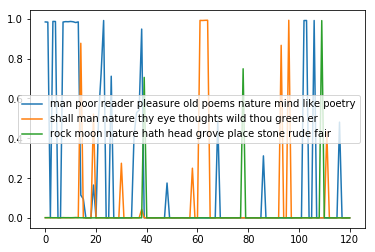

In [17]:
df[[topic_labels[4], topic_labels[5], topic_labels[8]]].plot()

**Figure 2**

This graph shows the pervasiveness of the "nature" topics throughout the text: while the x-axis represents the collection's progress from beginning (0) to end (120), the y-axis represents the prevalence of the topics, ranging from complete absence (0) to abundant presence (1.0). Each color corresponds to a different topic. The blue line represents the "poetics of nature" topic (Topic 4); the orange line represents the "human nature" topic (Topic 5);  and the green line represents the "natural world" topic (Topic 8).

Looking at the graph, we can see that the "poetics of nature" topic has the most peaks and fluctuates the most, appearing most frequently at the beginning and end of the text. The "human nature" topic also peaks often, appearing most frequently in the middle and end. By contrast, the "natural world" topic barely reaches any points of high prevalence. This topic appears least frequently, peaking only three times: once about a third of the way into the text, and twice in the second volume.

With this topic model, I explore the following question, which drives the rest of this paper: are these three topics _sufficiently distinct_ to be considered separate thematic groups, or is the text's "nature" too complex for statistical differentiation? I hypothesize that a concordance, co-occurrence, and close readings of nature-focused passages will confirm the presence of these topics, while also elucidating how "nature" eludes easy classification into any single topic. 

## A Concordance and Co-occurrence of "Nature"

Let's instantiate _Lyrical Ballads_ as a text object, and construct a "nature" concordance and co-occurrence to track the development of this motif, distantly and closely:

In [18]:
LB_instantiated = Text(LB_tokens)

In [19]:
LB_instantiated.concordance('nature', lines=57, width=115)

Displaying 57 of 57 matches:
 would require a space wholly disproportionate to the nature of a preface . For to treat the subject with the clea
y though not ostentatiously , the primary laws of our nature : chiefly as far as regards the manner in which we as
ncorporated with the beautiful and permanent forms of nature . The language too of these men is adopted ( purified
shall describe objects and utter sentiments of such a nature and in such connection with each other , that the und
en agitated by the great and simple affections of our nature . This object I have endeavoured in these short essay
ly associated with the great and beautiful objects of nature , as in THE BROTHERS ; or , as in the Incident of SIM
f which the elements are simple , belonging rather to nature than to manners , such as exist now and will probably
esting of their occupations , and the entire world of nature , from which I am at liberty to supply myself with en
ll upon the whole be in a state of enjoyment . Now 

As I hypothesized, the concordance confirms the presence of every generated topic. Some matches involve reflexively poetic representations of nature ("the beautiful and permanent forms of nature," "nature's immortality"). Some feature human nature, physically and emotionally ("the primary laws of our nature," "our physical nature," "He is by nature"). Others refer to the natural world, as a total and abstract entity ("Nature," "the eye of Nature," "the power of Nature"), and as the world of flora and fauna that exists apart from humanity ("nature's meads," "to look on nature"). 

Let's compare these concordance findings with a word co-occurrence. Which words co-occur most frequently with "nature"?

In [20]:
LB_instantiated.similar('nature')

it he i this him she years which in poetry look day life heart all
such food thought time one


These results slightly reinforce the topical distinctions generated above. The word "poetry" falls under the "poetics of nature" category, and the words "life," "heart," "he," "him," and "she" fall under the "human nature" category. However, none of these co-occurring words relate to the "natural world" category. This absence begins to unsettle the accuracy of the topic model. Below, I pressure the topic model further with close readings of nature-focused passages:

## Close Readings of Three "Nature" Passages

I begin this section with an excerpt from the second poem of the collection, "The Tables Turned." According to our topical graph, this passage should represent the "poetics of nature" topic: "And hark! how blithe the Throstle sings! / And he is no mean preacher: / Come forth into the light of things, / Let Nature be your teacher." (13-16). In this provocation, the speaker extrapolates the collective entity "Nature" from a singing "Throstle," deploying this bird as a synecdoche for nature as a whole. Then, the speaker personifies nature into "Nature," invoking it as a literally and figuratively enlightening "teacher." It is important to note that "Nature" can only assume the role of "teacher" through the poem's language; without this linguistic-aesthetic context, "Nature" could not plausibly be conjured as a figure for enlightenment. Thus, this passage does represent the "poetics of nature" topic, confirming the blue line that peaks at the beginning of the topical graph. The graph fails, nonetheless, to account for the importance of the natural world in this passage: what actually happens here is not an isolated peak of the "poetics of nature" topic, but a confluence of the "poetics of nature" and "natural world" topics.

So the topic model continues to crumble. Let's analyze another "nature" passage from the famous "Lines Written above Tintern Abbey," which ends the first volume (and should thus represent the "human" nature topic: ". . . Therefore am I still / A lover of the meadows and the woods, / And mountains; and of all that we behold / From this green earth; of all the mighty world / Of eye and ear, both what they half create, / And what perceive; well pleased to recognize / In nature and the language of the sense, / The anchor of my purest thoughts, . . ." (103-10). Through the senses ("Of eye and ear," "And what perceive," "language of the _sense_) and language itself ("_language_ of the sense"), the speaker brings together the natural world and his/her experience of it. Self-aware of him/herself as a human _in_ nature, the speaker signals his/her observing presence ("Therefore am _I_ still / A lover," "all that _we_ behold," "_my_ purest thoughts"). The speaker's self-referentiality as a subject _in_ nature contests the topic model's distinction between human nature and the natural world. Unsettling these topical divisions, the passage synthesizes--indeed synchronizes--the poetics of nature, human nature, and the natural world.

I conclude my critique of the topic model with an extract from "Ruth," which appears towards the end of the collection. Given its placement, this poem should represent the "natural world" topic: "Nor less to feed unhallow'd thought / The beauteous forms of nature wrought, / Fair trees and lovely flowers; / The breezes their own languor lent; / The stars had feelings which they sent / Into those magic bowers." (79-84). These lines compress aesthetically-pleasing plants ("The _beauteous_ forms of nature," "_fair_ trees," "_lovely_ flowers"), natural elements ("The breezes"), and astronomical bodies ("The stars"), pointing strongly to the "natural world" and "poetics of nature" topics. However, this is not an untouched scene of the natural world: the first line flags the presence of a human observer capable of "unhallow'd thought." Consequently, this passage also ushers in the "human nature" topic. The word "nature" brings together the natural world, the human observer, and the poetic context of "nature" into aesthetic simultaneity, revoking the topic model's clear-cut distinctions between the human and the natural.

## Conclusion

My close readings refute the topic model's tri-partite model of "nature"; however, my critique needs some qualification. Although the topic model fails to account for the semantic and figurative complexities of "nature" throughout the text, it still enables the reader to develop a vocabulary that can guide closer readings of the workings and shifts of "nature." This vocabulary--in my case, "poetics of nature," "human nature," and "the natural world"--works as a kind of exegetical spotlight or filter, providing the interpreter with basic tools for building more nuanced readings. 

The central argument of this paper can therefore be articulated in two ways, first with a _methodological_ focus, second with a _literary-critical_ stance:
1. Topic modeling fails to account for the simultaneous multidimensionality of "nature" throughout _Lyrical Ballads_, but it still generates meaningful categories for closer exploration of nature's intersecting (and at times conflicting) facets.
2. In _Lyrical Ballads_, "nature" does not operate as a constant and fixed entity; rather, as demonstrated by topic modeling and close readings guided by the terms of the generated topics, "nature" synthesizes and pressures three core senses: the poetics of nature, human nature, and the natural world.

We must allow both natures--the "Nature" of _Lyrical Ballads_ and the "nature" of the topic model--to be our teacher. 

## Works Cited

Blei, David. "Probabilistic Topic Models." _Commmunications of the ACM_, vol. 55, no. 4, 2012, pp. 77-84, http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf. Accessed 10 August 2018. 

"nature, n." OED Online, Oxford UP, June 2018, www.oed.com/view/Entry/125353. Accessed 10 August 2018.

Wordsworth, William, and S.T. Coleridge. _Lyrical Ballads_. Oxford UP: 2013.

### Wordcount Function

Please replace `Yourname-Final.ipynb` with the filename of this notebook. For instance, if my name is Jonathan, and I've renamed this notebook to `Jonathan-Final.ipynb`, I'd change `filename = 'Yourname-Final.ipynb'` below to `filename = 'Jonathan-Final.ipynb`. 

In [21]:
filename = 'MarcVasquez-Final.ipynb'

if filename == 'Yourname-Final.ipynb': 
    raise ValueError("You forgot to change the filename above!")

with open('MarcVasquez-Final.ipynb', encoding='utf-8') as f:
    nb = current.read(f, 'json')

wordCount = 0

for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        wordCount += len(cell['source'].replace('#', '').lstrip().split(' '))

# This is the word count of my instructions. 
# My instructions obviously don't count toward the final word count, 
tare = 533

wordCount = wordCount - tare

print("Total words: {}".format(wordCount))

if wordCount < 1000: 
    raise Warning('Your paper has not yet met the minimum required length.')
if wordCount > 2000: 
    raise Warning('Your paper has exceeded the maximum allowed length. Please edit for concision.')

Total words: 1921
